# 0. Imports

In [2]:
import pandas as pd
import numpy as np

from dotenv import load_dotenv
load_dotenv()
import os

from sklearn.model_selection import train_test_split

In [3]:
target_col = 'expensive'

# 1. Lendo base

In [4]:
path_raw = os.getenv('PATH_TO_SPLIT')
df = pd.read_csv(path_raw, sep=',')
# df = pd.read_csv(path_raw, sep=',')

In [5]:
df = df.drop(df.columns[0], axis=1)

In [6]:
df.sample(1)

,find_condominio,find_iptu,find_m_quadrado,is_academia,is_apertamento,is_churrasqueira,is_elevador,is_mobiliado,is_piscina,is_portaria,is_salao_festa,is_varanda,n_banheiros,n_garagens,n_quartos,expensive,Bairro
14436,1.0,1.0,40.0,0,1,1,0,0,1,1,1,0,1,1,2,0,Tamarineira


# 2. Dividindo entre treino e teste

In [8]:
df_1 = df.copy() 

In [9]:
df_1['Bairro'] = df_1['Bairro'].astype('category')
df_1['Bairro'] = df_1['Bairro'].cat.codes

In [10]:
X = df_1.drop(columns=[target_col])
y = df_1[target_col]

# Separando os dados em treinamento(75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# 3. Treinamento

## Decision Tree

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [12]:
dt = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_leaf=500)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=500, random_state=42)

Accuracy: 0.88


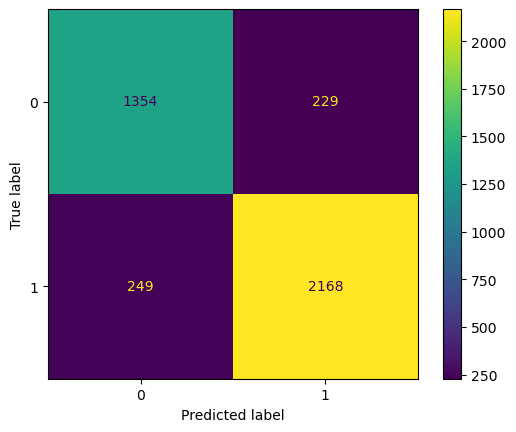

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1583
           1       0.90      0.90      0.90      2417

    accuracy                           0.88      4000
   macro avg       0.87      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

## Random forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, y_train)

In [17]:
y_pred = rf.predict(X_test)

Accuracy: 0.90


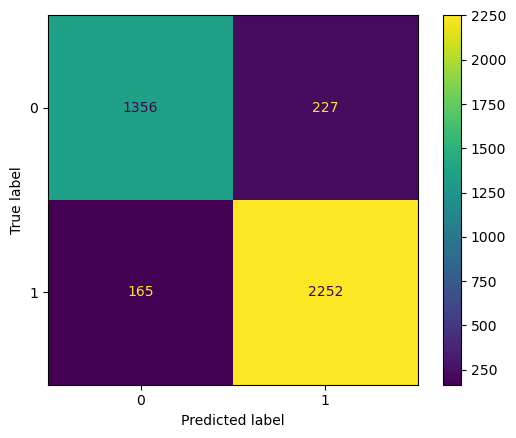

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1583
           1       0.91      0.93      0.92      2417

    accuracy                           0.90      4000
   macro avg       0.90      0.89      0.90      4000
weighted avg       0.90      0.90      0.90      4000



In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

### logist regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# lr = make_pipeline(StandardScaler(), LogisticRegression())

lr = LogisticRegression(max_iter = 20000)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

Accuracy: 0.77


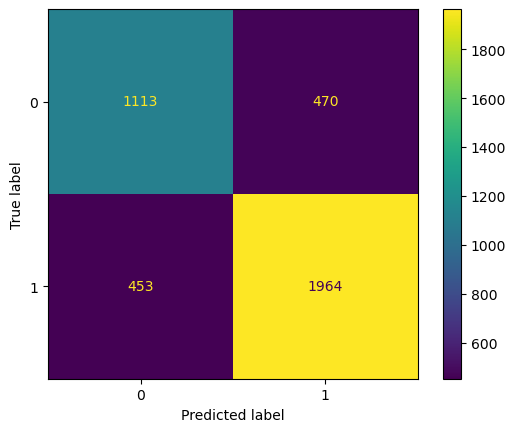

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71      1583
           1       0.81      0.81      0.81      2417

    accuracy                           0.77      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.77      0.77      0.77      4000



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Show the plot
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

## Analise Random Forest

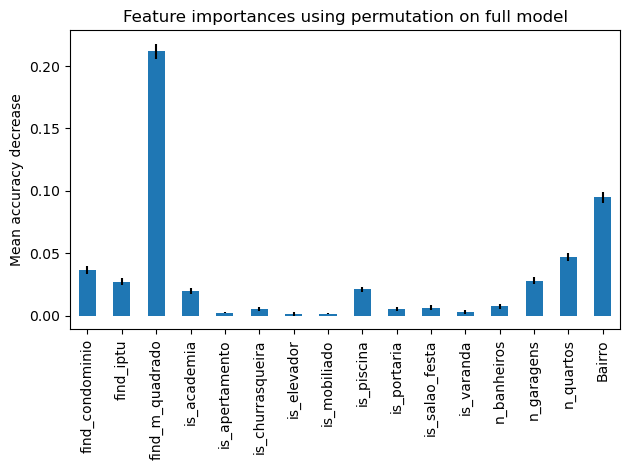

In [21]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(rf, X_test, y_test ,n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Olhando o PFI podemos ver algums comportamentos esperados, como a alta correlação de m^2 e o bairro.

A correlação com bairro é interessante pois vemos que o modelo utilizou bem a característica intríseca de cada bairro(utilizando para achar o melhor split em cada árvore que foi sorteado essa variável com um sample aleatório)

vemos que apenas 63 dos 79 bairros apareceram na base de teste, mesmo assim continuar importante como um todo

In [32]:
len(df['Bairro'].unique())

79

In [29]:
len(X_test['Bairro'].unique())

63

Vendo o PDP da coluna bairro conseguimos ver isso claramente

In [46]:
help(np.argmax)

Help on _ArrayFunctionDispatcher in module numpy:

argmax(a, axis=None, out=None, *, keepdims=<no value>)
    Returns the indices of the maximum values along an axis.
    
    Parameters
    ----------
    a : array_like
        Input array.
    axis : int, optional
        By default, the index is into the flattened array, otherwise
        along the specified axis.
    out : array, optional
        If provided, the result will be inserted into this array. It should
        be of the appropriate shape and dtype.
    keepdims : bool, optional
        If this is set to True, the axes which are reduced are left
        in the result as dimensions with size one. With this option,
        the result will broadcast correctly against the array.
    
        .. versionadded:: 1.22.0
    
    Returns
    -------
    index_array : ndarray of ints
        Array of indices into the array. It has the same shape as `a.shape`
        with the dimension along `axis` removed. If `keepdims` is set to T

In [49]:
display.pd_results[0]['values'][0][np.argmax(display.pd_results[0]['average'][0])]

9

In [50]:
df_1['Bairro'].value_counts()

Bairro
9     7553
41    1140
48    1045
20     999
76     882
      ... 
25       1
49       1
75       1
53       1
14       1
Name: count, Length: 79, dtype: int64

In [51]:
df['Bairro'].value_counts()

Bairro
Boa Viagem           7553
Imbiribeira          1140
Madalena             1045
Casa Amarela          999
Várzea                882
                     ... 
Coqueiral               1
Mangueira               1
Vasco da Gama           1
Nova Descoberta         1
Brejo de Beberibe       1
Name: count, Length: 79, dtype: int64

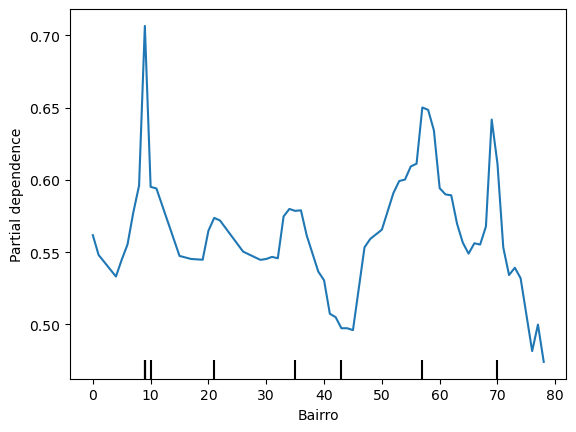

In [33]:
from sklearn.inspection import PartialDependenceDisplay

display  = PartialDependenceDisplay.from_estimator(rf, X_test, [15])

Vemos que imóveis em Boa Viagem o modelo aprendeu que tem mais probabildiade de pertencer a classe 1(ser 'caro')  

Acredito que esse modelo aprendeu bem a separar um bairro do outro, ja que vemos rapidas mudanças de um para o outro e nenhum sentido crescente ou decrecente.

Quer dizer, alguns bairros ajudam mais que outros a definir o preço do lugar, alguns bairros apresentam muitas residencias caras, enquanto outros, so apresentam residencias baratas. Além disso, alguns são heterogeneos em sua composição e por isso.

como vimos, ometro quadrado é uma feature importante, mas ela parece ser disparado a mais importante

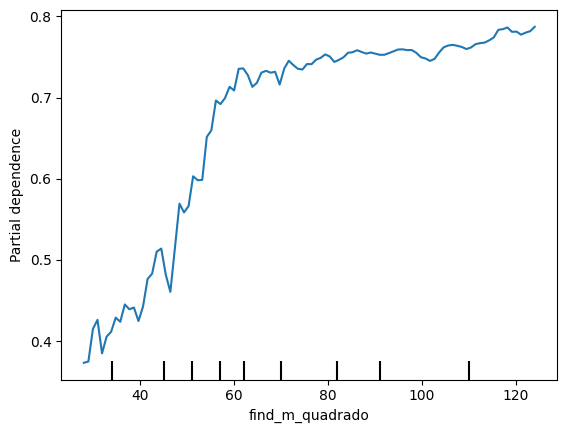

In [43]:
from sklearn.inspection import PartialDependenceDisplay

display  = PartialDependenceDisplay.from_estimator(rf, X_test, [2])

Vemos uma parte baixa no grafico, do inicio até 50 .Quer dizer que quando o metro quadrado é baixo, o modelo diz que a probabilidade de pertencer a classe 1(imóvel caro) é mais baixa, provavelmente por que outros fatores, como localização, se tornam bem mais importantes. Enquanto se um apartamento tem mais de 60 m^2 ele definitivamente é caro

o fato do metro quadrado ser tão importante, parece ter diminuido a importancia de features que claramente deveria ajudar como condominio e IPTU

### podemos fazer uma analise aqui sobre a parte mais dificil do dataset, entre 45 metros quadrados e 50

In [53]:
casa_dificil_df =  pd.concat([X_test, y_test], axis=1)
casa_dificil_df = df_1[(df_1['find_m_quadrado'] < 50) & (df_1['find_m_quadrado'] >= 45)]

In [56]:
X_dificil = casa_dificil_df.drop(columns=[target_col])
y_dificil = casa_dificil_df[target_col]

In [57]:
X_dificil['find_m_quadrado'].describe()

count    1547.000000
mean       46.442793
std         1.378941
min        45.000000
25%        45.000000
50%        46.000000
75%        47.000000
max        49.000000
Name: find_m_quadrado, dtype: float64

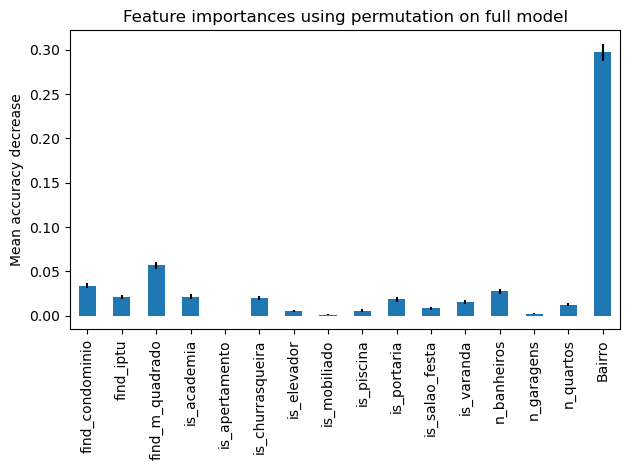

In [58]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(rf, X_dificil, y_dificil, n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

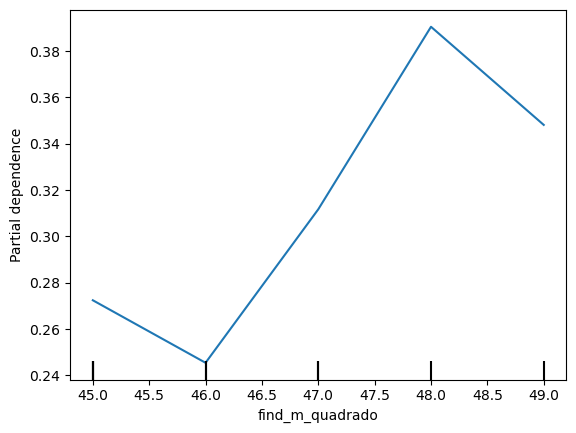

In [59]:
from sklearn.inspection import PartialDependenceDisplay

display  = PartialDependenceDisplay.from_estimator(rf, X_dificil, [2])

# Confiabilidade

para confiabilidade do modelo, vamos 

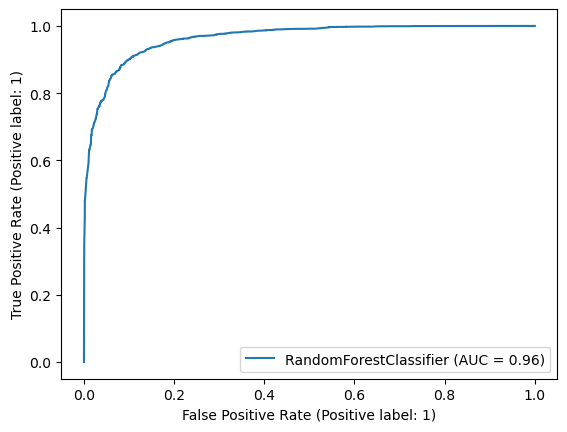

In [60]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(rf, X_test, y_test)

C:\Users\davim\AppData\Local\Temp\ipykernel_19620\3420713456.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rf.predict_proba(X_test))


<Axes: ylabel='Density'>

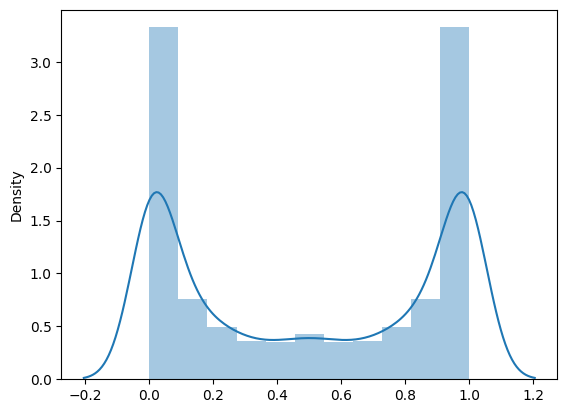

In [62]:
import seaborn as sns
sns.distplot(rf.predict_proba(X_test))

In [77]:
X_test['score'].mean()

KeyError: 'score'

In [85]:
X_test['score'].describe()

count    4000.000000
mean        0.386915
std         0.395060
min         0.000000
25%         0.010000
50%         0.203464
75%         0.820625
max         1.000000
Name: score, dtype: float64

In [88]:
rf.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- score


In [91]:

X_test = X_test.drop(columns=['score'])

X_test['score'] = rf.predict_proba(X_test)[:,0]

y_pred_dificil = y_pred[(X_test['score']>0.1) & (X_test['score']<0.6)]

Y_test_dificil = y_test[(X_test['score']>0.1) & (X_test['score']<0.6)]

accuracy_score(y_pred_dificil, Y_test_dificil)

0.6166832174776564

# APAGAR ESSA PARTE DEPOIS:

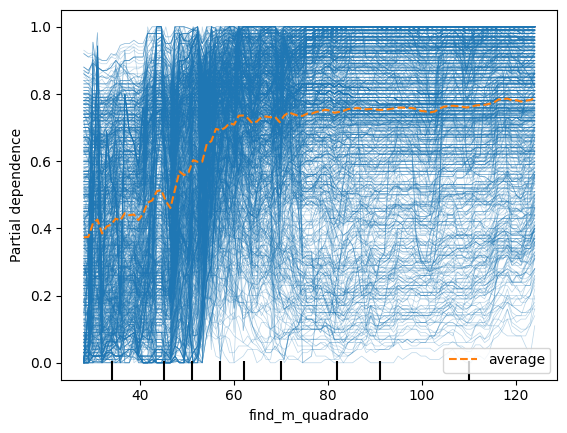

In [56]:
disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, ['find_m_quadrado'], kind='both')

In [50]:
# Importância das características
importances = rf.feature_importances_
feature_names = X.columns.tolist()
# Mostrar as importâncias
for feature, importance in zip(feature_names, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: find_condominio, Importance: 0.10360163661477254
Feature: find_iptu, Importance: 0.09702966397715923
Feature: find_m_quadrado, Importance: 0.3287165826921294
Feature: is_academia, Importance: 0.01899146161805833
Feature: is_apertamento, Importance: 0.005847705690402606
Feature: is_churrasqueira, Importance: 0.014866310939998293
Feature: is_elevador, Importance: 0.01316245228983987
Feature: is_mobiliado, Importance: 0.00786370224341196
Feature: is_piscina, Importance: 0.02287438440687135
Feature: is_portaria, Importance: 0.0146611953856236
Feature: is_salao_festa, Importance: 0.016356130922281206
Feature: is_varanda, Importance: 0.01646571838431203
Feature: n_banheiros, Importance: 0.03190689084610722
Feature: n_garagens, Importance: 0.059672116335676914
Feature: n_quartos, Importance: 0.09020689171630622
Feature: Bairro, Importance: 0.15777715593704922


In [51]:
list(X_test.columns)

['find_condominio',
 'find_iptu',
 'find_m_quadrado',
 'is_academia',
 'is_apertamento',
 'is_churrasqueira',
 'is_elevador',
 'is_mobiliado',
 'is_piscina',
 'is_portaria',
 'is_salao_festa',
 'is_varanda',
 'n_banheiros',
 'n_garagens',
 'n_quartos',
 'Bairro']

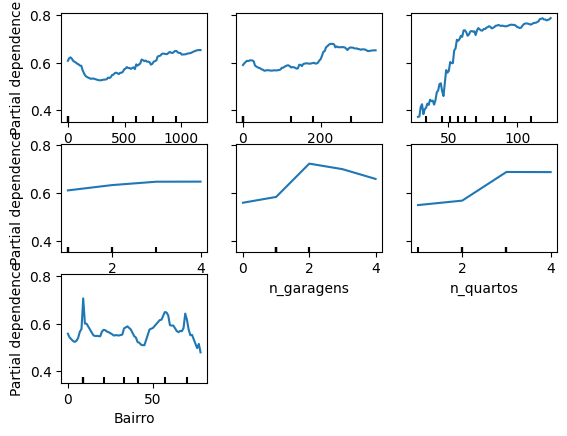

In [52]:
from sklearn.inspection import PartialDependenceDisplay

features = [0,1,2,12,13,14,15]

display  = PartialDependenceDisplay.from_estimator(rf, X_test, features)

In [53]:
disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, [[1,5,7]],grid_resolution=20, target=[1])

ValueError: Each entry in features must be either an int, a string, or an iterable of size at most 2.

In [ ]:
disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, [1], kind='both', target=[1])

In [ ]:
from sklearn.decomposition import PCA

# Step 2: Perform PCA
pca = PCA(n_components=2)  # Number of components to keep
principal_components = pca.fit_transform(df_2)

# Create a DataFrame with the principal components
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Step 3: Analyze the results
explained_variance = pca.explained_variance_ratio_

print("Principal Components DataFrame:")
print(pc_df)
print("\nExplained Variance Ratio:")
print(explained_variance)

Gostariamos também de entender relações bivariadas, uma casa com elevador

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(mlp, X_test, y_test ,n_repeats=100, random_state=0)

forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()

forest_importances.plot.bar(yerr=result.importances_std, ax=ax)

ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()